<a href="https://colab.research.google.com/github<URI_PLACEHOLDER>" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

--2021-04-14 19:51:28--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13927 (14K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  13.60K  --.-KB/s    in 0s      

2021-04-14 19:51:28 (94.3 MB/s) - ‘odc_colab.py’ saved [13927/13927]

Module datacube was not found; installing it...
Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Module hdmedians was not found; installing it...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...


Downloads an existing index and populates the new ODC environment with it.

In [2]:
from odc_colab import populate_db
populate_db(gee=True)

No database file supplied. Downloading default index.


<a id="top"></a>
# Vegetation Change

This notebook uses changes in the Normalized Difference Vegetation Index (NDVI) to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral index in each of those time periods. Significant changes in NDVI (vegetation greenness) are coincident with land change, as long as the comparisons are done between similar time periods (seasons or years). Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. It is expected that this algorithm can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments. In some cases the impacts may be negative (deforestation, mining, burning, drought) or positive (regrowth, improved soil moisture). 

It should also be noted that the selection of the baseline and analysis time period is critical. First, the two time periods should be similar (season, year) so that the vegetation state can be compared in similar weather conditions. Second, the time periods should be sufficiently clear (non-cloudy) data. If the baseline or analysis mosaic (composite of images) is contaminated with clouds, it will impact the results. 

## <span id="connect_dc">Connect to the Data Cube [&#9652;](#top)</span>

In [3]:
import warnings
# Supress Warning 
warnings.filterwarnings('ignore')

from odc_gee import earthengine
dc = earthengine.Datacube(app='Vegetation_Change')

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = earthengine.Datacube()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=UY8dVAr10A__8Kte1gxbQ6a0SRyS-BC-QFqOhpBRYzQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7uheKK6rQpVRXS2Knu8DB_3TEGXiWHn1s1OHhDJFtJPFyro5ToqKI

Successfully saved authorization token.


/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,
/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [4]:
# Select a Product and Platform
product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [5]:
# Select an analysis region (Latitude-Longitude) 

# Mining Region near Obuasi, Ghana 
# Baseline = 12/23/13, Analysis = 1/6/19 
# NOTE: These are clear scenes at similar times of the year. 
# Use the Cloud Statistics notebook to evaluate cloud cover.

latitude = (6.0985, 6.2675)
longitude = (-2.050, -1.8629)

In [6]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

In [11]:
from datetime import datetime

# Select the start and end periods for your analysis products (Year,Month,Day).
# These time windows will be used to make a median mosaic, so typically pick a year length (or more)
# or select a small window surrounding a clear single date (use Cloud Statistics notebook).
# Also, be sure to evaluate the RGB mosaics (below) to affirm they are not full of clouds.

# Select the baseline time period (start and end)
baseline_time_period = ('2013-12-22', '2013-12-24')

# Select the analysis time period (start and end)
analysis_time_period = ('2019-01-05', '2019-01-07')

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>  

In [12]:
baseline_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                      time=baseline_time_period) 

In [13]:
analysis_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                      time=analysis_time_period) 

In [14]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask_baseline = landsat_qa_clean_mask(baseline_ds, platform=platform)
baseline_ds = baseline_ds.where(cloud_mask_baseline)

cloud_mask_analysis = landsat_qa_clean_mask(analysis_ds, platform=platform)
analysis_ds = analysis_ds.where(cloud_mask_analysis)

## Create a Median Mosaic for the Baseline and Analysis Time Periods

In [15]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
baseline_composite = create_median_mosaic(baseline_ds, cloud_mask_baseline)
analysis_composite = create_median_mosaic(analysis_ds, cloud_mask_analysis)

## <span id="anomalies">Calculate NDVI Anomaly Product [&#9652;](#top)</span>  

In [16]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [17]:
parameter_baseline_composite = NDVI(baseline_composite)
parameter_analysis_composite = NDVI(analysis_composite)
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

## Show Baseline RGB, Analysis RGB and Anomaly Products

In [18]:
import matplotlib.pyplot as plt
from utils.data_cube_utilities.dc_rgb import rgb
from matplotlib.cm import RdYlGn
RdYlGn.set_bad('black',1.)

In [19]:
# Define the significant anomaly range for Plot #4
# The typical loss range is <0. Choose < -0.1 or < -0.2.
# The typical gain range is >0. Choose > 0.1 or > 0.2. 

loss_range  = parameter_anomaly < -0.2
gain_range  = parameter_anomaly > 0.2

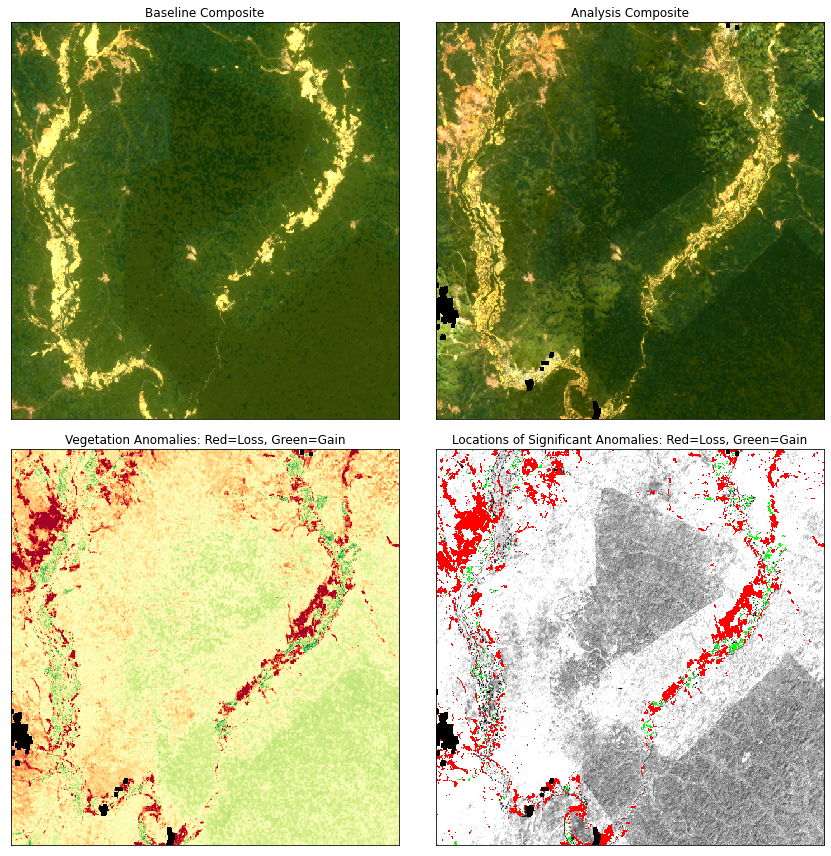

In [20]:
import xarray as xr
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(12,12))

for sub_ax in ax.flatten():
    sub_ax.set_facecolor('black')

baseline_rgb = baseline_composite[['red', 'green', 'blue']].to_array()
analysis_rgb = analysis_composite[['red', 'green', 'blue']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
lw_qtl, up_qtl = 0.02, 0.98
rgb_vmin = min(baseline_rgb.quantile(lw_qtl).values,analysis_rgb.quantile(lw_qtl).values)
rgb_vmax = max(baseline_rgb.quantile(up_qtl).values,analysis_rgb.quantile(up_qtl).values)

# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold
# NOTE: Clouds in either the baseline or analysis images will be removed from the anomaly product

## Plot #1 = Baseline RGB (upper left)
axes_image = baseline_rgb.plot.imshow(ax=ax[0,0], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #2 = Analysis RGB (upper right)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #3 = Total Anomaly (lower left)
parameter_anomaly.plot(ax=ax[1,0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

## Plot #4 = Anomaly Threshold (lower right)

# Analysis composite grayscale background
plt4_bkg_band = 'swir1' # The band to use as the background image.
plt4_rgb = np.repeat(analysis_composite[plt4_bkg_band].where(cloud_mask_baseline.sum('time').astype(np.bool))\
                     .values[:,:,np.newaxis],3,axis=2)

# Selected a range of SWIR1 values (0.001 to 0.600) to lighten image background 
# Users may also try values of 0.02 and 0.98
min_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.001)
max_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.600)
plt4_rgb = np.interp(plt4_rgb, (min_bkg, max_bkg), [0,1])

# Significant anomaly color overlays
color_green = np.array([0,1,0]) # green
color_red   = np.array([1,0,0]) # red
plt4_rgb[loss_range] = color_red
plt4_rgb[gain_range] = color_green

# Plot
plt4_coords = dict(analysis_composite.coords)
rgb_coord_arr = np.array(['red', 'green', 'blue'])
rgb_coord_da = xr.DataArray(rgb_coord_arr,name='rgb',dims=['rgb'],coords={'rgb': rgb_coord_arr})
plt4_coords.update({'rgb': rgb_coord_da})
plt4_rgb_da = xr.DataArray(plt4_rgb, coords=plt4_coords,dims=list(analysis_composite.dims) + ['rgb'])
plt4_rgb_da.plot.imshow(ax=ax[1,1])

# Titles for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Locations of Significant Anomalies: Red=Loss, Green=Gain'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()